# 상업용 부동산 가격모형

In [40]:
# package load
import pandas as pd
import numpy as np
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import statsmodels.api as sm 


# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# Pandas option
pd.set_option('display.max_columns', None)

# Dataset Generating

In [41]:
# import seoul roads
# 도로정보
seoul_road = gpd.GeoDataFrame.from_file('data/서울시위치정보/Z_KAIS_TL_SPRD_MANAGE_11000.shp', encoding='cp949')
seoul_road = seoul_road[['RN','geometry']]

In [42]:
# real estate data load
df_re = pd.read_csv('data/국토교통부 실거래가.csv', encoding='utf-8', usecols = ['도로명','전용/연면적(㎡)','거래금액(만원)','층','건축년도','건축물주용도'])
df_re.columns= ['도로명','건축물주용도','전용면적','거래금액','층','건축년도']  # type: ignore
df_re = df_re.loc[df_re.건축물주용도.isin(['제2종근린생활','제1종근린생활','판매']),:]
df_re = df_re.dropna(axis=0).reset_index(drop=True)

In [43]:
df_re = df_re.drop(index = np.where(~df_re.도로명.isin(seoul_road.RN))[0], axis=0).reset_index(drop=True) # 도로명 존재하지 않는 데이터 삭제

In [44]:
# 1층 외 나머지층 구분
df_re['층'] = np.where(df_re['층']==1, 1, 0)

In [45]:
# 거래금액 to float
for i in range(len(df_re)):
    df_re.at[i,'거래금액'] = df_re.at[i,'거래금액'].replace(',','',-1)

df_re['거래금액'] = df_re['거래금액'].astype('float')

df_re['건축년도'] = df_re['건축년도'].astype('int')

df_re['건축년도'] = 2021-df_re['건축년도']

In [46]:
# 주용도 to dummies
df_re = pd.concat([df_re.drop('건축물주용도',axis=1),pd.get_dummies(df_re.건축물주용도, drop_first=True)], axis=1)

In [47]:
seoul_road = seoul_road.loc[seoul_road.RN.isin(df_re.도로명.unique()),:]

In [48]:
seoul_road = seoul_road.dissolve(by='RN', as_index=False)

## 각 도로에 대한 범죄데이터 결합

### 전국 112신고접수 데이터
- 스마트치안빅데이터플랫폼 데이터셋

In [49]:
datals = os.listdir('data/전국112신고접수')
datals.sort()
datals = datals[-13:-1] # 2021년도 데이터

In [50]:
# columns
colnames = pd.read_csv('data/전국112신고접수/columns.csv', encoding='cp949')
colnames = colnames[' 컬럼영문명']
colnames.name = None

In [51]:
# data merge
df_112 = pd.DataFrame(columns=colnames)

for name in datals:
    df_i = pd.read_csv('data/전국112신고접수/'+ name, encoding='utf-8', header=None)
    df_i.columns = colnames
    df_112 = pd.concat([df_112, df_i], axis=0)

df_112 = df_112[df_112.columns.drop(['ACPT_YM'])]

In [52]:
# aggregate
df_112 = df_112.groupby('PLCST_NM', as_index=False).agg('sum')

In [53]:
# 서울 경찰서만 추리기
df_112 = df_112[df_112['PLCST_NM'].str.contains('서울')].reset_index(drop=True)
df_112 = df_112.set_index('PLCST_NM')
df_112.head(3)

,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,ACPT_EMERG_TYPE_CVAPP,ACPT_EMERG_TYPE_ETC,OCRN_DOTW_SNDD,OCRN_DOTW_MON,OCRN_DOTW_TUE,OCRN_DOTW_WED,OCRN_DOTW_THU,OCRN_DOTW_FRI,OCRN_DOTW_SAT,OCRN_TIZN_00,OCRN_TIZN_01,OCRN_TIZN_02,OCRN_TIZN_03,OCRN_TIZN_04,OCRN_TIZN_05,OCRN_TIZN_06,OCRN_TIZN_07,OCRN_TIZN_08,OCRN_TIZN_09,OCRN_TIZN_10,OCRN_TIZN_11,OCRN_TIZN_12,OCRN_TIZN_13,OCRN_TIZN_14,OCRN_TIZN_15,OCRN_TIZN_16,OCRN_TIZN_17,OCRN_TIZN_18,OCRN_TIZN_19,OCRN_TIZN_20,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23
PLCST_NM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
서울강남,125929,64971,31098,29860,0,1124,23192,72898,14709,14006,14075,16097,18115,19040,18970,20897,18735,8030,6194,4422,3195,2641,2128,1703,2062,2714,3536,4366,4715,4727,5201,5449,5752,5424,5729,6222,5921,6240,8243,11746,9569
서울강동,96374,48968,26491,20914,1,901,21108,54722,8492,11151,13058,13200,13242,13294,13628,14518,15434,5513,4089,2880,2113,1978,1380,1375,1550,2227,2811,3438,3626,3681,3906,4179,4587,4654,4647,4864,5095,5218,6629,8607,7327
서울강북,79765,40683,24067,15015,0,492,17288,46253,6605,9127,11355,10664,10500,11074,11092,12292,12788,4730,3531,2528,1877,1539,1138,1148,1241,1625,2307,2770,2897,2931,3162,3374,3641,3681,3914,4034,4490,4721,5748,7123,5615


In [54]:
# 변수생성
df_112['총신고건수'] = df_112['RPRT_CASCNT_WHOL']
df_112['긴급신고비율'] = df_112['ACPT_EMERG_TYPE_EMERG'] / df_112['RPRT_CASCNT_WHOL']
df_112['야간신고비율'] = (df_112['OCRN_TIZN_22']+df_112['OCRN_TIZN_23']+df_112['OCRN_TIZN_00']+df_112['OCRN_TIZN_01']+df_112['OCRN_TIZN_02']) / df_112['RPRT_CASCNT_WHOL']

df_112 = df_112[['총신고건수','긴급신고비율','야간신고비율']]

## 생활안전지도 데이터
생활안전지도 api에서 추출한(`safemap.ipynb`) 데이터 불러오기
> 범죄 종류 : 살인,강도,강간,절도,폭력,방화,마약,약취유인,도박,전체

In [55]:
df_safety = gpd.GeoDataFrame.from_file('safemap.gpkg')
df_safety = df_safety[df_safety['polc_se'].isin(['03_파출소', '02_지구대'])]
df_safety.columns = ['polc_nm', 'plcstn_nm', 'polc_se', '살인', '강도', '강간', '절도',
       '폭력', '방화', '마약', '약취', '도박', '전체범죄', '시군구',
       'geometry']
df_safety.shape

(243, 15)

In [56]:
df_safety = df_safety.to_crs(epsg=5181) # epsg:5181

In [57]:
df_safety = df_safety.join(df_112, on='polc_nm') # 112 신고데이터 결합

#### 각 도로에서 가장 가까운 지구대/파출소 찾기
> 대부분 파출소 및 지구대의 관할은 도로명을 기준으로 구성되므로 설정

In [58]:
# 각 도로에서 가장 가까운 지구대/파출소 찾기

seoul_road['nearest_pol_idx'] = 0 # 가장 가까운 지구대/파출소 index from df_safety

for i in tqdm(range(len(seoul_road))):
    dist_i = df_safety.geometry.distance(seoul_road.geometry[i])
    idx_i = np.argmin(dist_i)
    seoul_road.at[i,'nearest_pol_idx'] = idx_i

100%|██████████| 1503/1503 [00:01<00:00, 756.09it/s]


In [59]:
len(seoul_road.nearest_pol_idx.unique()) # 233개 지구대/파출소 선정됨

233

In [60]:
seoul_road = seoul_road.join(df_safety.drop('geometry',axis=1), on='nearest_pol_idx')

In [61]:
seoul_road.head(3)

,RN,geometry,nearest_pol_idx,polc_nm,plcstn_nm,polc_se,살인,강도,강간,절도,폭력,방화,마약,약취,도박,전체범죄,시군구,총신고건수,긴급신고비율,야간신고비율
0,63로,"LINESTRING (194253.695 446471.534, 194263.679 ...",97,서울동작,노량진,02_지구대,1,5,5,5,5,4,2,1,4,5,동작구,76788,0.008126,0.293575
1,가락로,"MULTILINESTRING ((209148.910 444494.789, 20915...",138,서울송파,방이,02_지구대,5,1,5,3,5,4,5,3,3,4,송파구,139303,0.007688,0.301566
2,가락로11길,"MULTILINESTRING ((209208.602 444752.418, 20920...",139,서울송파,삼전,02_지구대,3,1,3,2,4,1,2,3,3,3,송파구,139303,0.007688,0.301566


### 상권데이터

In [62]:
# 상권데이터 로드
commercial_area = gpd.GeoDataFrame.from_file('df_final.gpkg')
commercial_area = commercial_area.iloc[:,21:]

In [63]:
# 도로데이터에 결합할 상권데이터 변수 생성(float)
new_cols = commercial_area.columns[:-1]
seoul_road[new_cols]=0.0

In [65]:
# 각 도로기준 어떤 상권과 Intersection인지 체크하여 상권데이터의 평균값 사용

for i in tqdm(range(len(seoul_road))):
    area_ls = np.where(seoul_road.geometry.intersects(commercial_area.geometry[i]))[0]
    if len(area_ls) == 0:
        pass
    elif len(area_ls) == 1:
        data_i = commercial_area.iloc[area_ls[0],:-1]
        seoul_road.loc[i,new_cols] = data_i
    else:
        data_i = commercial_area.iloc[area_ls,:-1].mean()
        seoul_road.loc[i,new_cols] = data_i


100%|██████████| 1503/1503 [00:07<00:00, 189.70it/s]


## 도로 인근 버스정류장 및 지하철역 개수 정보
버스정류장 : 도로로부터 50M 이내 정류장 개수</br>
지하철역 : 도로로부터 500M 이내 역 개수

In [66]:
# 버스정류장
df_bus = pd.read_csv('data/busstops.csv', encoding='cp949')
gdf_bus = gpd.GeoDataFrame(df_bus, geometry=gpd.points_from_xy(x=df_bus['X좌표'], y=df_bus['Y좌표'], crs='WGS84'))
gdf_bus = gdf_bus.to_crs(epsg=5181)

In [67]:
# 지하철역
df_sub = pd.read_csv('data/station_coordinate.csv', encoding='utf-8')
gdf_sub = gpd.GeoDataFrame(df_sub, geometry=gpd.points_from_xy(x=df_sub.lng, y=df_sub.lat, crs='WGS84'))
gdf_sub = gdf_sub.to_crs(epsg=5181)

In [68]:
# Count(3min)
seoul_road['Bus'] = 0
seoul_road['Subway'] = 0

for i in tqdm(range(len(seoul_road))):
    # distance function
    bus_i = np.where(gdf_bus.geometry.distance(seoul_road.geometry[i])<50.0)[0] # 1D array
    sub_i = np.where(gdf_sub.geometry.distance(seoul_road.geometry[i])<500.0)[0] # 1D array
    seoul_road.at[i,'Bus'] = len(bus_i)
    seoul_road.at[i,'Subway'] = len(sub_i)

seoul_road.head(3)

100%|██████████| 1503/1503 [01:35<00:00, 15.73it/s]


,RN,geometry,nearest_pol_idx,polc_nm,plcstn_nm,polc_se,살인,강도,강간,절도,폭력,방화,마약,약취,도박,전체범죄,시군구,총신고건수,긴급신고비율,야간신고비율,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,시간대_1_생활인구_수,시간대_2_생활인구_수,시간대_3_생활인구_수,시간대_4_생활인구_수,시간대_5_생활인구_수,시간대_6_생활인구_수,아파트_단지_수,아파트_평균_시가,개업_점포_수_비요식업,개업_점포_수_요식업,점포_수_비요식업,점포_수_요식업,폐업_점포_수_비요식업,폐업_점포_수_요식업,프랜차이즈_점포_수_비요식업,프랜차이즈_점포_수_요식업,매출액,매출건수,Bus,Subway
0,63로,"LINESTRING (194253.695 446471.534, 194263.679 ...",97,서울동작,노량진,02_지구대,1,5,5,5,5,4,2,1,4,5,동작구,76788,0.008126,0.293575,4.423208e+06,2139565.0,2283642.0,621893.666667,621755.333333,831201.666667,742060.333333,620308.333333,985988.666667,1.217085e+06,937519.333333,527928.0,508527.0,675477.333333,556672.0,58.0,1.751643e+08,17.333333,9.0,151.666667,45.0,13.666667,9.0,25.333333,28.666667,5.203435e+10,891487.0,3,0
1,가락로,"MULTILINESTRING ((209148.910 444494.789, 20915...",138,서울송파,방이,02_지구대,5,1,5,3,5,4,5,3,3,4,송파구,139303,0.007688,0.301566,2.695350e+05,128647.0,140890.0,58040.000000,27355.000000,34201.000000,44560.000000,40951.000000,64426.000000,4.485900e+04,57567.000000,39322.0,42285.0,53985.000000,31514.0,2.0,1.327468e+08,0.000000,0.0,17.000000,3.0,1.000000,0.0,0.000000,0.000000,4.386982e+08,10121.0,16,3
2,가락로11길,"MULTILINESTRING ((209208.602 444752.418, 20920...",139,서울송파,삼전,02_지구대,3,1,3,2,4,1,2,3,3,3,송파구,139303,0.007688,0.301566,2.464231e+06,1159290.5,1304936.0,447938.000000,307443.000000,349816.500000,376659.500000,388068.000000,594303.500000,7.077020e+05,514093.500000,279723.5,275197.0,376208.500000,311303.0,43.0,1.610331e+08,6.500000,4.5,81.000000,28.0,10.500000,5.5,24.000000,27.000000,2.417203e+10,604404.5,1,2


## 서울시 유흥업소 정보
스마트치안빅데이터플랫폼의 **도시구분과 관서별 유흥시설 데이터(LH)** 활용 </br>
> 전국단위 데이터이므로 서울시 경찰관서 관내로 한정(2711개)

In [69]:
df_bars = gpd.GeoDataFrame.from_file('data/KLH_15_20211115_G_001/KLH_15_20211115_G_001.shp')
df_bars = df_bars[df_bars.PS_NM.str.startswith('서울')]
df_bars = df_bars[['PS_NM','PSS_NM','geometry']].reset_index(drop=True)
df_bars = df_bars.to_crs(epsg=5181)

In [70]:
# 각 도로 인근(반경 100m)에 포함된 유흥업소 개수 count(10s)
seoul_road['유흥업소'] = 0

for i in tqdm(range(len(seoul_road))):
    # within function
    bar_i = np.where(df_bars.geometry.distance(seoul_road.geometry[i])<100.0)[0] # 1D array
    seoul_road.at[i,'유흥업소'] = len(bar_i)

seoul_road.head(3)

100%|██████████| 1503/1503 [00:21<00:00, 71.16it/s]


,RN,geometry,nearest_pol_idx,polc_nm,plcstn_nm,polc_se,살인,강도,강간,절도,폭력,방화,마약,약취,도박,전체범죄,시군구,총신고건수,긴급신고비율,야간신고비율,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,시간대_1_생활인구_수,시간대_2_생활인구_수,시간대_3_생활인구_수,시간대_4_생활인구_수,시간대_5_생활인구_수,시간대_6_생활인구_수,아파트_단지_수,아파트_평균_시가,개업_점포_수_비요식업,개업_점포_수_요식업,점포_수_비요식업,점포_수_요식업,폐업_점포_수_비요식업,폐업_점포_수_요식업,프랜차이즈_점포_수_비요식업,프랜차이즈_점포_수_요식업,매출액,매출건수,Bus,Subway,유흥업소
0,63로,"LINESTRING (194253.695 446471.534, 194263.679 ...",97,서울동작,노량진,02_지구대,1,5,5,5,5,4,2,1,4,5,동작구,76788,0.008126,0.293575,4.423208e+06,2139565.0,2283642.0,621893.666667,621755.333333,831201.666667,742060.333333,620308.333333,985988.666667,1.217085e+06,937519.333333,527928.0,508527.0,675477.333333,556672.0,58.0,1.751643e+08,17.333333,9.0,151.666667,45.0,13.666667,9.0,25.333333,28.666667,5.203435e+10,891487.0,3,0,0
1,가락로,"MULTILINESTRING ((209148.910 444494.789, 20915...",138,서울송파,방이,02_지구대,5,1,5,3,5,4,5,3,3,4,송파구,139303,0.007688,0.301566,2.695350e+05,128647.0,140890.0,58040.000000,27355.000000,34201.000000,44560.000000,40951.000000,64426.000000,4.485900e+04,57567.000000,39322.0,42285.0,53985.000000,31514.0,2.0,1.327468e+08,0.000000,0.0,17.000000,3.0,1.000000,0.0,0.000000,0.000000,4.386982e+08,10121.0,16,3,16
2,가락로11길,"MULTILINESTRING ((209208.602 444752.418, 20920...",139,서울송파,삼전,02_지구대,3,1,3,2,4,1,2,3,3,3,송파구,139303,0.007688,0.301566,2.464231e+06,1159290.5,1304936.0,447938.000000,307443.000000,349816.500000,376659.500000,388068.000000,594303.500000,7.077020e+05,514093.500000,279723.5,275197.0,376208.500000,311303.0,43.0,1.610331e+08,6.500000,4.5,81.000000,28.0,10.500000,5.5,24.000000,27.000000,2.417203e+10,604404.5,1,2,2


In [71]:
# Combine with df_re
df_re = df_re.join(seoul_road.set_index('RN'), on='도로명')

In [72]:
df_re.drop('geometry', axis=1)
df_re.to_csv('assets.csv', index=False)
seoul_road.to_file('seoul_road.gpkg')

# Preprocessing

In [97]:
df = pd.read_csv('assets.csv')
df['아파트_단지_수'] = df['아파트_단지_수'].fillna(0)

In [98]:
df.columns = ['도로명', '전용면적', '거래금액', '1층유무', '연식', '용도_제2종근린생활', '용도_판매', 'geometry',
       'nearest_pol_idx', 'polc_nm', 'plcstn_nm', 'polc_se', '살인', '강도', '강간',
       '절도', '폭력', '방화', '마약', '약취', '도박', '전체범죄', '시군구', '총신고건수', '긴급신고비율',
       '야간신고비율', '총_생활인구', '남성_생활인구', '여성_생활인구', '연령대_10_생활인구',
       '연령대_20_생활인구', '연령대_30_생활인구', '연령대_40_생활인구', '연령대_50_생활인구',
       '연령대_60_이상_생활인구', '시간대_1_생활인구', '시간대_2_생활인구', '시간대_3_생활인구',
       '시간대_4_생활인구', '시간대_5_생활인구', '시간대_6_생활인구', '아파트_단지', '아파트_평균_시가',
       '개업_점포_비요식업', '개업_점포_요식업', '점포_비요식업', '점포_요식업', '폐업_점포_비요식업',
       '폐업_점포_요식업', '프랜차이즈_점포_비요식업', '프랜차이즈_점포_요식업', '매출액', '매출건수',
       'Bus', 'Subway', '유흥업소']  # type: ignore

In [99]:
df = df.drop(['도로명','nearest_pol_idx','polc_nm','plcstn_nm','polc_se','시군구','아파트_평균_시가'], axis=1)

In [100]:
# data type
crimes = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약',
       '약취', '도박', '전체범죄']
for n in crimes:
    df[n] = df[n].astype('int')

In [101]:
# 심야생활인구비율
df['생활인구_야간비율'] = df['시간대_6_생활인구'] / df['총_생활인구'] # 시간대 6(21-24시)
df['생활인구_심야비율'] = df['시간대_1_생활인구'] / df['총_생활인구'] # 시간대 1(00-06시)
df['생활인구_여성비율'] = df['여성_생활인구'] / (df['총_생활인구'])
df.head(1)

,전용면적,거래금액,1층유무,연식,용도_제2종근린생활,용도_판매,geometry,살인,강도,강간,절도,폭력,방화,마약,약취,도박,전체범죄,총신고건수,긴급신고비율,야간신고비율,총_생활인구,남성_생활인구,여성_생활인구,연령대_10_생활인구,연령대_20_생활인구,연령대_30_생활인구,연령대_40_생활인구,연령대_50_생활인구,연령대_60_이상_생활인구,시간대_1_생활인구,시간대_2_생활인구,시간대_3_생활인구,시간대_4_생활인구,시간대_5_생활인구,시간대_6_생활인구,아파트_단지,개업_점포_비요식업,개업_점포_요식업,점포_비요식업,점포_요식업,폐업_점포_비요식업,폐업_점포_요식업,프랜차이즈_점포_비요식업,프랜차이즈_점포_요식업,매출액,매출건수,Bus,Subway,유흥업소,생활인구_야간비율,생활인구_심야비율,생활인구_여성비율
0,103.88,34000.0,0,10,0,0,LINESTRING (206742.3057670072 443683.830173950...,2,1,1,1,1,1,1,1,1,1,88076,0.009094,0.275342,2048509.5,1015926.5,1032582.5,261370.0,227767.5,254593.5,276697.0,341679.0,686402.0,454632.5,422484.0,276291.5,276354.0,365369.5,253378.0,45.0,5.5,7.5,121.5,39.5,7.0,8.0,12.0,21.0,2.890391e+10,992804.0,0,2,1,0.123689,0.221933,0.504065


In [102]:
# Drop nonusing population features
df = df.drop(['남성_생활인구', '여성_생활인구',
       '연령대_10_생활인구', '연령대_20_생활인구', '연령대_30_생활인구', '연령대_40_생활인구',
       '연령대_50_생활인구', '연령대_60_이상_생활인구', '시간대_1_생활인구', '시간대_2_생활인구',
       '시간대_3_생활인구', '시간대_4_생활인구', '시간대_5_생활인구', '시간대_6_생활인구'], axis=1)

### Descriptive

In [103]:
# describe
df.describe().round(3)

,전용면적,거래금액,1층유무,연식,용도_제2종근린생활,용도_판매,살인,강도,강간,절도,폭력,방화,마약,약취,도박,전체범죄,총신고건수,긴급신고비율,야간신고비율,총_생활인구,아파트_단지,개업_점포_비요식업,개업_점포_요식업,점포_비요식업,점포_요식업,폐업_점포_비요식업,폐업_점포_요식업,프랜차이즈_점포_비요식업,프랜차이즈_점포_요식업,매출액,매출건수,Bus,Subway,유흥업소,생활인구_야간비율,생활인구_심야비율,생활인구_여성비율
count,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6379.000,6.379000e+03,6379.000,6379.000,6369.000,6379.000,6369.000,6379.000,6369.000,6379.000,6369.000,6.371000e+03,6.371000e+03,6379.000,6379.000,6379.000,5251.000,5251.000,5251.000
mean,67.918,58873.479,0.359,16.292,0.493,0.205,2.603,2.439,2.440,2.724,2.719,2.511,2.519,2.169,2.395,2.711,92398.755,0.008,0.285,2.719209e+06,37.823,10.779,9.783,146.327,52.560,11.557,8.996,27.674,48.729,3.874231e+10,1.717809e+06,19.069,3.475,8.854,0.124,0.245,0.523
std,160.946,126369.296,0.480,11.699,0.500,0.404,1.539,1.566,1.599,1.515,1.527,1.418,1.558,1.623,1.563,1.527,29191.309,0.001,0.027,2.601458e+06,41.029,14.034,13.390,222.357,76.686,18.126,14.180,40.196,92.001,7.418790e+10,2.823260e+06,27.403,4.206,15.497,0.013,0.048,0.027
min,3.320,300.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,28589.000,0.004,0.199,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000e+00,0.000000e+00,0.000,0.000,0.000,0.046,0.058,0.387
25%,21.450,15000.000,0.000,6.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,72970.000,0.007,0.267,8.083610e+05,7.000,3.000,2.333,40.000,16.400,3.000,2.000,4.000,8.000,5.721065e+09,2.618275e+05,2.000,1.000,1.000,0.119,0.219,0.513
50%,36.400,30000.000,0.000,16.000,0.000,0.000,2.000,2.000,2.000,3.000,2.000,2.000,2.000,1.000,2.000,2.000,94619.000,0.008,0.292,2.300315e+06,29.800,7.000,6.400,93.000,32.000,6.500,5.000,16.200,20.000,1.490142e+10,8.028995e+05,9.000,2.000,2.000,0.127,0.256,0.526
75%,63.200,59066.000,1.000,23.000,1.000,0.000,4.000,4.000,4.000,4.000,4.000,3.000,4.000,3.000,4.000,4.000,114534.000,0.009,0.300,3.950659e+06,53.000,13.000,11.200,155.000,55.000,12.633,9.833,33.000,43.250,3.399717e+10,1.800969e+06,29.000,4.000,9.000,0.132,0.277,0.537
max,1852.630,1512230.000,1.000,121.000,1.000,1.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,139303.000,0.010,0.341,1.767099e+07,369.000,118.000,111.000,3042.000,831.000,235.000,154.000,478.000,763.000,1.250806e+12,2.384320e+07,195.000,27.000,99.000,0.152,0.359,0.598


In [ ]:
## Correlation
# heatmap > 연령대별 생활인구는 제외
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(20,20))

corr = df.corr().abs() # 연령대 포함한 생활인구변수 제외
mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, cmap='Blues', annot=True, fmt='.2f')
plt.savefig('plots/corr.png', facecolor='white')
plt.show()

전체범죄, 매출건수, 매출액 상관관계 처리 논의 필요</br>
> 전체범죄 및 매출건수 제외

In [105]:
df = df.drop(['전체범죄','매출건수'], axis=1)

점포 수 간에 높은 상관관계 > 매출액 및 건수에도 영향
> 비율형 변수로 생성(총 7개)

In [106]:
df['개업율_요식업'] = df['개업_점포_요식업'] / df['점포_요식업']
df['폐업율_요식업'] = df['폐업_점포_요식업'] / df['점포_요식업']
df['프랜차이즈비율_요식업'] = df['프랜차이즈_점포_요식업'] / df['점포_요식업']

df['개업율_비요식업'] = df['개업_점포_비요식업'] / df['점포_비요식업']
df['폐업율_비요식업'] = df['폐업_점포_비요식업'] / df['점포_비요식업']
df['프랜차이즈비율_비요식업'] = df['프랜차이즈_점포_비요식업'] / df['점포_비요식업']

df['요식업비율'] = df['점포_요식업'] / (df['점포_요식업'] + df['점포_비요식업'])

In [107]:
# NA drop
df = df.dropna(axis=0)

In [108]:
df = df.drop(df.columns[df.columns.str.contains('점포')].tolist(), axis=1)

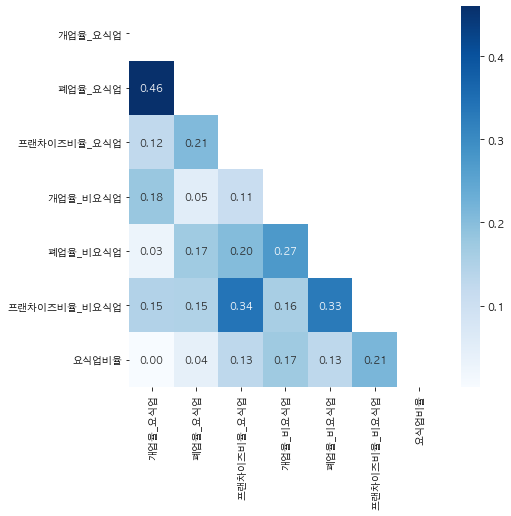

In [109]:
# heatmap for new variables
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(7,7))

corr = df.iloc[:,-7:].corr().abs() # 연령대 포함한 생활인구변수 제외
mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, cmap='Blues', annot=True, fmt='.2f')
plt.savefig('plots/corr_new.png', facecolor='white')
plt.show()

## Outlier Detection

### Boxplot

In [110]:
cols = df.columns.drop(['1층유무','용도_제2종근린생활','용도_판매','geometry'])
cols_crime = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박'] # 9종 범죄
len(cols)

31

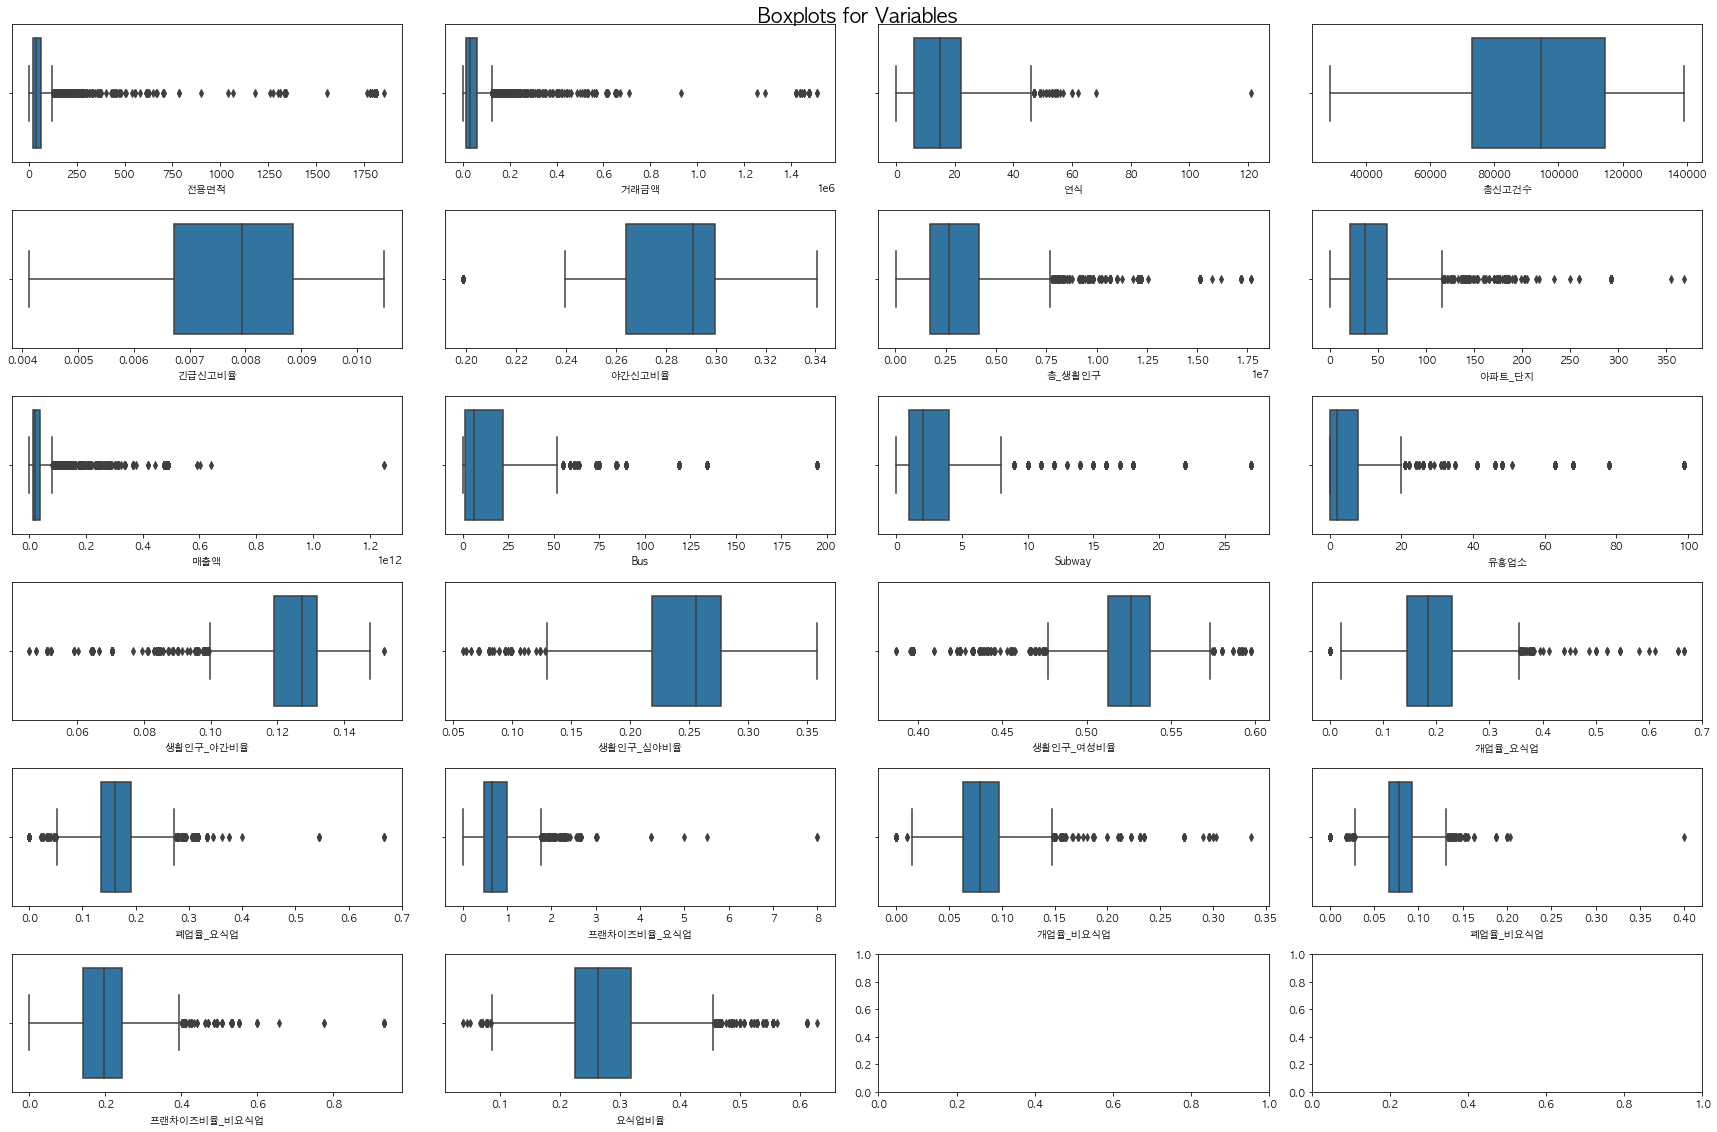

In [111]:
figs, axes = plt.subplots(nrows=6,ncols=4, figsize=(24,16))
for idx, col in enumerate([x for x in cols if x not in cols_crime]):
    ax_i = axes[idx//4, idx%4]
    sns.boxplot(x=df[col], ax=ax_i)
plt.suptitle('Boxplots for Variables', fontsize=20)
plt.tight_layout()
plt.savefig('plots/Box.png', facecolor='white') # 면적당 매매가(1,3)에 비해 조절가격(1,4)가 더 outlier에 robust하다

In [112]:
# z-score for responsive variable
col = '거래금액'
zscore =((df[col]-df[col].mean())/df[col].std()).abs()
zscore.sort_values(ascending=False).head(3)
# np.where(zscore_y>4)

811    10.938199
810    10.938199
828    10.658681
Name: 거래금액, dtype: float64

In [113]:
# # outlier drop
# df = df.drop(index=94, axis=0)

### KDE

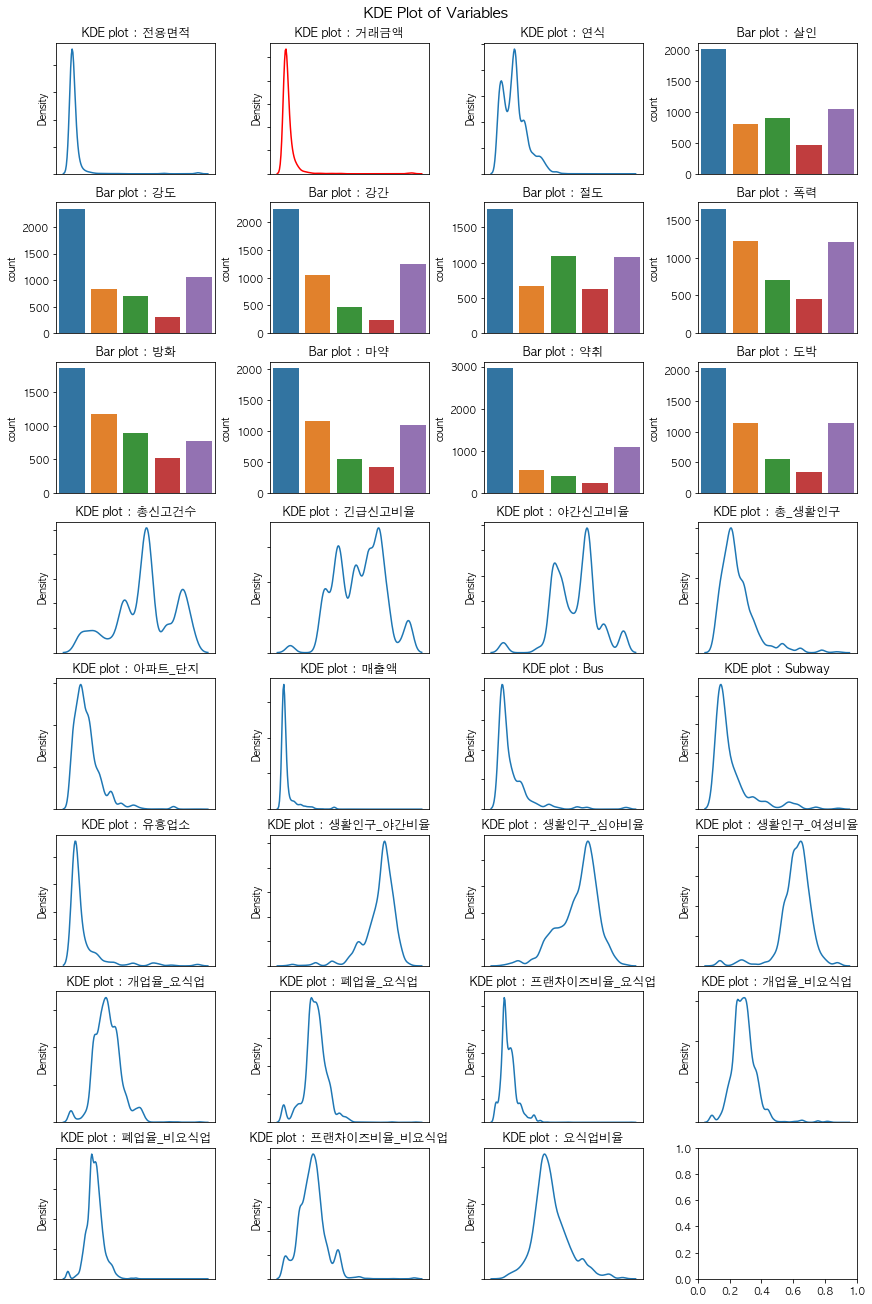

In [114]:
# KDE plots of Variables

figs, axes = plt.subplots(nrows=8, ncols=4, figsize = (12,18), constrained_layout=True)

cols_crime = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박','전체범죄']

for idx, col in enumerate(cols):
    ax_i = axes[idx//4, idx%4]
    if col in cols_crime:
        sns.countplot(data=df, x=col, ax=ax_i)
        ax_i.set_title(f'Bar plot : {col}')
        ax_i.get_xaxis().set_visible(False)
    else:
        if col == '거래금액':
            sns.kdeplot(df[col], ax = ax_i, color='red')
        else:
            sns.kdeplot(df[col], ax = ax_i)
        ax_i.set_title(f'KDE plot : {col}')
        ax_i.tick_params(labelleft=False,labelbottom=False)
        ax_i.get_xaxis().set_visible(False)

plt.suptitle('KDE Plot of Variables', fontsize=15)
plt.savefig('plots/KDE.png', facecolor='white')
plt.show()

In [115]:
from scipy.stats import shapiro
df_shapiro = pd.DataFrame(columns=['col','statistic','pval'])
ls_col = []
ls_stats = []
ls_pval = []
for col in [x for x in cols if x not in cols_crime]: # except crime data
    shapiro_col = shapiro(df[col])
    ls_col.append(col)
    ls_stats.append(shapiro_col[0])
    ls_pval.append(shapiro_col[1])
    
df_shapiro['col'] = ls_col
df_shapiro['statistic'] = ls_stats
df_shapiro['pval'] = ls_pval
df_shapiro[df_shapiro.pval<0.5].round(4)

/Users/dangchan/miniforge3/envs/spatial/lib/python3.8/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,col,statistic,pval
0,전용면적,0.2601,0.0
1,거래금액,0.3189,0.0
2,연식,0.9351,0.0
3,총신고건수,0.9446,0.0
4,긴급신고비율,0.9689,0.0
5,야간신고비율,0.9398,0.0
6,총_생활인구,0.8317,0.0
7,아파트_단지,0.8078,0.0
8,매출액,0.5248,0.0
9,Bus,0.6169,0.0


In [116]:
df.to_csv('assets_preprocessed.csv', index=False)

# Analysis

## Raw OLS

In [4]:
df = pd.read_csv('assets_preprocessed.csv')

In [5]:
# Ordered Categorical Variable
cols_crime = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박']

t = pd.CategoricalDtype(categories=[1,2,3,4,5], ordered=True)
df[cols_crime] = df[cols_crime].astype(t)
df = df.drop('geometry',axis=1)

In [6]:
X = sm.add_constant(df.drop('거래금액',axis=1), prepend=True)
y = np.log(df.거래금액)

In [7]:
model = sm.OLS(endog=y, exog=X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   거래금액   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     90.62
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:55:57   Log-Likelihood:                -6960.2
No. Observations:                5233   AIC:                         1.399e+04
Df Residuals:                    5199   BIC:                         1.421e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.5215      0.337     25.260      0.000       7.860       9.183
전용면적             0.0033   8.13e-05     40.696      0.000       0.003       0.003
1층유무             0.1947      0.028      6.996      0.000       0.140       0.249
연식              -0.0074      0.001     -6.203      0.000      -0.010      -0.005
용도_제2종근린생활      -0.0763      0.030     -2.540      0.011      -0.135      -0.017
용도_판매           -0.8117      0.041    -19.822      0.000      -0.892      -0.731
살인               0.0391      0.010      3.821      0.000       0.019       0.059
강도              -0.0812      0.010     -7.806      0.000      -0.102      -0.061
강간               0.0362      0.020      1.783      0.075      -0.004       0.076
절도               0.1462      0.019      7.852      0.000       0.110       0.183
폭력              -0.0795      0.019     -4.295      0.000      -0.116      -0.043
방화              -0.0474      0.011     -4.407      0.000      -0.069      -0.026
마약              -0.0223      0.012     -1.838      0.066      -0.046       0.001
약취              -0.0170      0.009     -1.958      0.050      -0.034    1.68e-05
도박              -0.0460      0.010     -4.508      0.000      -0.066      -0.026
총신고건수        -1.007e-06   5.27e-07     -1.909      0.056   -2.04e-06     2.7e-08
긴급신고비율         171.2865     11.973     14.305      0.000     147.813     194.760
야간신고비율          -1.8405      0.602     -3.058      0.002      -3.020      -0.661
총_생활인구        6.944e-09   7.23e-09      0.960      0.337   -7.23e-09    2.11e-08
아파트_단지          -0.0002      0.000     -0.571      0.568      -0.001       0.001
매출액          -5.765e-13   2.16e-13     -2.673      0.008   -9.99e-13   -1.54e-13
Bus              0.0063      0.001      4.992      0.000       0.004       0.009
Subway           0.0103      0.005      2.070      0.038       0.001       0.020
유흥업소            -0.0107      0.002     -5.129      0.000      -0.015      -0.007
생활인구_야간비율        1.3826      1.819      0.760      0.447      -2.184       4.949
생활인구_심야비율       -1.1093      0.519     -2.138      0.033      -2.126      -0.092
생활인구_여성비율        1.9556      0.557      3.508      0.000       0.863       3.049
개업율_요식업         -1.0165      0.214     -4.744      0.000      -1.437      -0.596
폐업율_요식업          0.4735      0.260      1.822      0.069      -0.036       0.983
프랜차이즈비율_요식업     -0.0200      0.033     -0.608      0.544      -0.085       0.045
개업율_비요식업         0.1290      0.440      0.293      0.769      -0.733       0.991
폐업율_비요식업         2.7111      0.605      4.481      0.000       1.525       3.897
프랜차이즈비율_비요식업     0.0254      0.159      0.160      0.873      -0.286       0.336
요식업비율            0.5069      0.175      2.899      0.004       0.164       0.850
==============================================================================
Omnibus

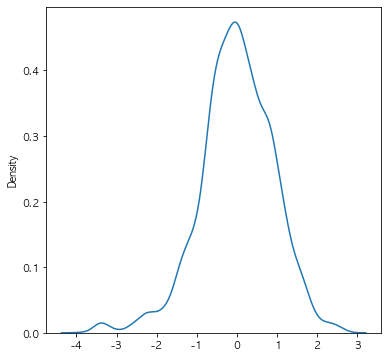

In [8]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.kdeplot(res.resid, ax=ax)
plt.savefig('plots/assetprice_kde.png',facecolor='white')
plt.show()


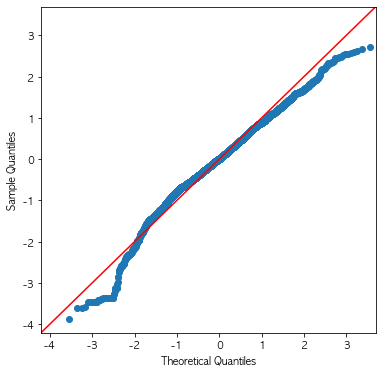

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
sm.qqplot(res.resid,line='45', ax=ax)
plt.savefig('plots/assetprice_QQplot.png',facecolor='white')
plt.show()


## Transformation

In [13]:
from scipy.stats import shapiro
cols = df.columns


df_shapiro = pd.DataFrame(columns=['col','statistic','pval'])
ls_col = []
ls_stats = []
ls_pval = []
for col in [x for x in cols if x not in cols_crime]: # except crime data
    shapiro_col = shapiro(df[col])
    ls_col.append(col)
    ls_stats.append(shapiro_col[0])
    ls_pval.append(shapiro_col[1])
    
df_shapiro['col'] = ls_col
df_shapiro['statistic'] = ls_stats
df_shapiro['pval'] = ls_pval
df_shapiro[df_shapiro.pval<0.5].round(4)

/Users/dangchan/miniforge3/envs/spatial/lib/python3.8/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,col,statistic,pval
0,전용면적,0.2601,0.0
1,거래금액,0.3189,0.0
2,1층유무,0.6091,0.0
3,연식,0.9351,0.0
4,용도_제2종근린생활,0.6366,0.0
5,용도_판매,0.4777,0.0
6,총신고건수,0.9446,0.0
7,긴급신고비율,0.9689,0.0
8,야간신고비율,0.9398,0.0
9,총_생활인구,0.8317,0.0


In [74]:
df_shapiro.loc[df_shapiro.pval<0.05,'col'].tolist()

['전용면적',
 '거래금액',
 '1층유무',
 '연식',
 '용도_제2종근린생활',
 '용도_판매',
 '총신고건수',
 '긴급신고비율',
 '야간신고비율',
 '총_생활인구',
 '아파트_단지',
 '매출액',
 'Bus',
 'Subway',
 '유흥업소',
 '생활인구_야간비율',
 '생활인구_심야비율',
 '생활인구_여성비율',
 '개업율_요식업',
 '폐업율_요식업',
 '프랜차이즈비율_요식업',
 '개업율_비요식업',
 '폐업율_비요식업',
 '프랜차이즈비율_비요식업',
 '요식업비율']

In [14]:
# Transform -> 로그변환후 표준화
from copy import deepcopy
df_trans = deepcopy(df)

for col in df_shapiro.loc[df_shapiro.pval<0.05,'col']:
    df_trans[col] = np.log1p(df_trans[col])
    df_trans[col] = (df_trans[col] - df_trans[col].mean()) / df_trans[col].std()

In [15]:
X_tf = sm.add_constant(df_trans.drop('거래금액',axis=1), prepend=True)
y_tf = df_trans['거래금액']

In [16]:
model_new = sm.OLS(endog=y_tf, exog=X_tf)
res_new = model_new.fit()
res_new.summary() # R2 from 0.365 to 0.646

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   거래금액   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     287.1
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:56:48   Log-Likelihood:                -4709.8
No. Observations:                5233   AIC:                             9488.
Df Residuals:                    5199   BIC:                             9711.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0778      0.024      3.206      0.001       0.030       0.125
전용면적             0.7651      0.009     83.346      0.000       0.747       0.783
1층유무             0.1596      0.009     18.048      0.000       0.142       0.177
연식              -0.0832      0.009     -9.399      0.000      -0.101      -0.066
용도_제2종근린생활      -0.0241      0.010     -2.476      0.013      -0.043      -0.005
용도_판매           -0.0405      0.011     -3.735      0.000      -0.062      -0.019
살인               0.0280      0.007      4.288      0.000       0.015       0.041
강도              -0.0391      0.007     -5.798      0.000      -0.052      -0.026
강간              -0.0064      0.013     -0.492      0.622      -0.032       0.019
절도               0.1091      0.012      9.050      0.000       0.085       0.133
폭력              -0.0424      0.012     -3.523      0.000      -0.066      -0.019
방화              -0.0352      0.007     -5.044      0.000      -0.049      -0.022
마약              -0.0252      0.008     -3.259      0.001      -0.040      -0.010
약취              -0.0113      0.006     -2.000      0.046      -0.022      -0.000
도박              -0.0194      0.007     -2.916      0.004      -0.032      -0.006
총신고건수           -0.0370      0.010     -3.745      0.000      -0.056      -0.018
긴급신고비율           0.1917      0.010     19.229      0.000       0.172       0.211
야간신고비율          -0.0545      0.010     -5.216      0.000      -0.075      -0.034
총_생활인구           0.0242      0.014      1.690      0.091      -0.004       0.052
아파트_단지          -0.0078      0.014     -0.564      0.573      -0.035       0.019
매출액             -0.0176      0.013     -1.350      0.177      -0.043       0.008
Bus             -0.0988      0.013     -7.432      0.000      -0.125      -0.073
Subway           0.2276      0.013     17.971      0.000       0.203       0.252
유흥업소            -0.0349      0.014     -2.487      0.013      -0.062      -0.007
생활인구_야간비율     4.689e-05      0.016      0.003      0.998      -0.032       0.032
생활인구_심야비율       -0.0379      0.017     -2.265      0.024      -0.071      -0.005
생활인구_여성비율        0.0494      0.010      5.078      0.000       0.030       0.068
개업율_요식업         -0.0096      0.010     -0.956      0.339      -0.029       0.010
폐업율_요식업         -0.0153      0.010     -1.482      0.138      -0.036       0.005
프랜차이즈비율_요식업     -0.0144      0.012     -1.223      0.221      -0.037       0.009
개업율_비요식업        -0.0261      0.010     -2.653      0.008      -0.045      -0.007
폐업율_비요식업         0.0505      0.010      5.216      0.000       0.032       0.069
프랜차이즈비율_비요식업     0.0129      0.011      1.222      0.222      -0.008       0.034
요식업비율            0.0272      0.010      2.860      0.004       0.009       0.046
==============================================================================
Omnibus

#### VIF check

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame({'variable' : col_i, 'VIF' : variance_inflation_factor(model_new.exog, i)} for i, col_i in enumerate(model_new.exog_names) if col_i != 'const')
vif[vif.VIF>5] # 강간, 절도, 폭력

,variable,VIF
7,강간,6.570807
8,절도,5.013496
9,폭력,5.102003


In [18]:
# 절도 제외
X_tf_new = sm.add_constant(df_trans.drop(['거래금액','절도'],axis=1), prepend=True)
y_tf_new = df_trans['거래금액']

In [19]:
model_tf_new = sm.OLS(endog=y_tf_new, exog=X_tf_new)
res_tf_new = model_tf_new.fit()
res_tf_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   거래금액   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     289.1
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:56:54   Log-Likelihood:                -4750.7
No. Observations:                5233   AIC:                             9567.
Df Residuals:                    5200   BIC:                             9784.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1051      0.024      4.328      0.000       0.057       0.153
전용면적             0.7665      0.009     82.860      0.000       0.748       0.785
1층유무             0.1581      0.009     17.749      0.000       0.141       0.176
연식              -0.0838      0.009     -9.388      0.000      -0.101      -0.066
용도_제2종근린생활      -0.0214      0.010     -2.184      0.029      -0.041      -0.002
용도_판매           -0.0309      0.011     -2.840      0.005      -0.052      -0.010
살인               0.0317      0.007      4.832      0.000       0.019       0.045
강도              -0.0228      0.007     -3.487      0.000      -0.036      -0.010
강간               0.0550      0.011      4.884      0.000       0.033       0.077
폭력              -0.0264      0.012     -2.200      0.028      -0.050      -0.003
방화              -0.0260      0.007     -3.740      0.000      -0.040      -0.012
마약              -0.0302      0.008     -3.887      0.000      -0.045      -0.015
약취              -0.0125      0.006     -2.183      0.029      -0.024      -0.001
도박              -0.0114      0.007     -1.721      0.085      -0.024       0.002
총신고건수           -0.0491      0.010     -4.979      0.000      -0.068      -0.030
긴급신고비율           0.1864      0.010     18.589      0.000       0.167       0.206
야간신고비율          -0.0446      0.010     -4.258      0.000      -0.065      -0.024
총_생활인구           0.0068      0.014      0.474      0.635      -0.021       0.035
아파트_단지           0.0091      0.014      0.661      0.508      -0.018       0.036
매출액             -0.0059      0.013     -0.453      0.650      -0.032       0.020
Bus             -0.1074      0.013     -8.030      0.000      -0.134      -0.081
Subway           0.2313      0.013     18.136      0.000       0.206       0.256
유흥업소            -0.0305      0.014     -2.160      0.031      -0.058      -0.003
생활인구_야간비율        0.0033      0.016      0.199      0.842      -0.029       0.035
생활인구_심야비율       -0.0352      0.017     -2.086      0.037      -0.068      -0.002
생활인구_여성비율        0.0431      0.010      4.409      0.000       0.024       0.062
개업율_요식업         -0.0044      0.010     -0.435      0.664      -0.024       0.015
폐업율_요식업         -0.0175      0.010     -1.677      0.094      -0.038       0.003
프랜차이즈비율_요식업     -0.0135      0.012     -1.138      0.255      -0.037       0.010
개업율_비요식업        -0.0213      0.010     -2.155      0.031      -0.041      -0.002
폐업율_비요식업         0.0430      0.010      4.424      0.000       0.024       0.062
프랜차이즈비율_비요식업     0.0168      0.011      1.572      0.116      -0.004       0.038
요식업비율            0.0333      0.010      3.485      0.000       0.015       0.052
==============================================================================
Omnibus:                      376.809   Durbin-Watson:                   0.908
Prob(Omni

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame({'variable' : col_i, 'VIF' : variance_inflation_factor(model_tf_new.exog, i)} for i, col_i in enumerate(model_tf_new.exog_names) if col_i != 'const')
vif[vif.VIF>5] # no variable more than vif 5

,variable,VIF


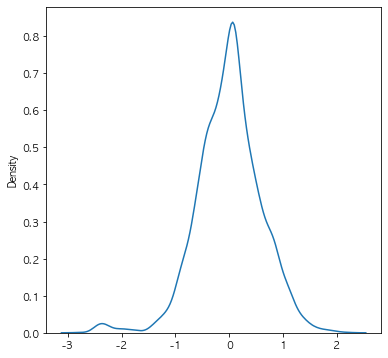

In [21]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.kdeplot(res_tf_new.resid, ax=ax)
plt.savefig('plots/assetprice_kde.png',facecolor='white')
plt.show()

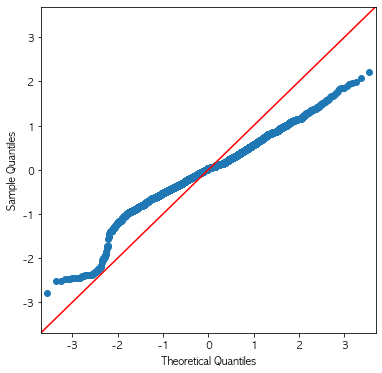

In [22]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
sm.qqplot(res_tf_new.resid,line='45', ax=ax)
plt.savefig('plots/assetprice_QQplot.png',facecolor='white')
plt.show()

## Feature Importance & Regression 종합
Gradient Boosting Machine의 feature importance + reg result from OLS

In [23]:
# load feature importance

df_imp = pd.read_csv('featureimportance.csv')
df_imp = df_imp.set_index('Col')

In [24]:
df_res = df_imp.join([res_tf_new.params[1:].rename('coef'),res_tf_new.pvalues[1:].rename('p-values')])
df_res = df_res.sort_values(by='featureimportance', ascending=False)

In [75]:
# Feature Selection with p-val<0.05
df_res_sig = df_res.loc[df_res['p-values']<0.05,:].round(4)

In [77]:
df_res_sig.to_csv('coefs.csv',index=True)